<a href="https://colab.research.google.com/github/mahapara2411/Sentiment-Analysis/blob/master/Sentiment_Analysis_using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [83]:
import numpy as np
import pandas as pd
import pickle
from collections import defaultdict
import re
from bs4 import BeautifulSoup
import sys
import os
os.environ['KERAS_BACKEND']='theano' # Why theano why not
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout
from keras.models import Model
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
plt.switch_backend('agg')
%matplotlib inline

In [84]:
#Upload the Dataset
from google.colab import files
uploaded = files.upload()

Saving Demo1 clean.csv to Demo1 clean (3).csv


In [85]:
# Dataset is now stored in a Pandas Dataframe
import io
data = pd.read_csv(io.BytesIO(uploaded['Demo1 clean.csv']))

In [86]:
data.head()

,Unnamed: 0,Hotel_id,Hotel,Title,Users,Reviews,Text_Clean,Rating,tokens,Sentiment
0,0,AVwc252WIN2L1WUfpqLP,Rancho Valencia Resort Spa,Best romantic vacation ever!!!!,Paula,Our experience at Rancho Valencia was absolute...,experience rancho valencia absolutely perfect ...,5,"['experience', 'rancho', 'valencia', 'absolute...",Positive
1,1,AVwc252WIN2L1WUfpqLP,Rancho Valencia Resort Spa,Sweet sweet serenity,D,Amazing place. Everyone was extremely warm and...,amazing place everyone extremely warm welcomin...,5,"['amazing', 'place', 'everyone', 'extremely', ...",Positive
2,2,AVwc252WIN2L1WUfpqLP,Rancho Valencia Resort Spa,Amazing Property and Experience,Ron,We booked a 3 night stay at Rancho Valencia to...,booked 3 night stay rancho valencia play tenni...,5,"['booked', '3', 'night', 'stay', 'rancho', 'va...",Positive
3,3,AVwdOclqIN2L1WUfti38,Aloft Arundel Mills,"Never again...beware, if you want sleep.",jaeem2016,Currently in bed writing this for the past hr ...,currently bed writing past hr 12 dogs barking ...,2,"['currently', 'bed', 'writing', 'past', 'hr', ...",Negative
4,4,AVwdOclqIN2L1WUfti38,Aloft Arundel Mills,ALWAYS GREAT STAY...,MamaNiaOne,I live in Md and the Aloft is my Home away fro...,live md aloft home away homewe stayed 1 night ...,5,"['live', 'md', 'aloft', 'home', 'away', 'homew...",Positive


In [87]:
data['Sentiment'] = data['Sentiment'].apply(lambda x: 0 if x == 'Negative' else 1)


In [88]:
data.head(50)

,Unnamed: 0,Hotel_id,Hotel,Title,Users,Reviews,Text_Clean,Rating,tokens,Sentiment
0,0,AVwc252WIN2L1WUfpqLP,Rancho Valencia Resort Spa,Best romantic vacation ever!!!!,Paula,Our experience at Rancho Valencia was absolute...,experience rancho valencia absolutely perfect ...,5,"['experience', 'rancho', 'valencia', 'absolute...",1
1,1,AVwc252WIN2L1WUfpqLP,Rancho Valencia Resort Spa,Sweet sweet serenity,D,Amazing place. Everyone was extremely warm and...,amazing place everyone extremely warm welcomin...,5,"['amazing', 'place', 'everyone', 'extremely', ...",1
2,2,AVwc252WIN2L1WUfpqLP,Rancho Valencia Resort Spa,Amazing Property and Experience,Ron,We booked a 3 night stay at Rancho Valencia to...,booked 3 night stay rancho valencia play tenni...,5,"['booked', '3', 'night', 'stay', 'rancho', 'va...",1
3,3,AVwdOclqIN2L1WUfti38,Aloft Arundel Mills,"Never again...beware, if you want sleep.",jaeem2016,Currently in bed writing this for the past hr ...,currently bed writing past hr 12 dogs barking ...,2,"['currently', 'bed', 'writing', 'past', 'hr', ...",0
4,4,AVwdOclqIN2L1WUfti38,Aloft Arundel Mills,ALWAYS GREAT STAY...,MamaNiaOne,I live in Md and the Aloft is my Home away fro...,live md aloft home away homewe stayed 1 night ...,5,"['live', 'md', 'aloft', 'home', 'away', 'homew...",1
5,5,AVwdOclqIN2L1WUfti38,Aloft Arundel Mills,Wonderful stay,kevan777,I stayed here with my family for my daughters ...,stayed family daughters wedding accommodating ...,5,"['stayed', 'family', 'daughters', 'wedding', '...",1
6,6,AVwdOclqIN2L1WUfti38,Aloft Arundel Mills,Worth the money,Princess F,Beautiful rooms and the nicest people working ...,beautiful rooms nicest people working front de...,5,"['beautiful', 'rooms', 'nicest', 'people', 'wo...",1
7,7,AVwdOclqIN2L1WUfti38,Aloft Arundel Mills,Great Hotel Experiece!,DebMurphy57,We stayed here while visiting Maryland Live!. ...,stayed visiting maryland live cute hotel great...,5,"['stayed', 'visiting', 'maryland', 'live', 'cu...",1
8,8,AVwdOclqIN2L1WUfti38,Aloft Arundel Mills,Short stay for business.,kayleighwillswim1224,"I travel a lot with my job, so I'm constantly ...",travel lot job im constantly staying hotels co...,5,"['travel', 'lot', 'job', 'im', 'constantly', '...",1
9,9,AVwePiAX_7pvs4fzBSAl,Hampton Inn Suites PortlandVancouver,Amazing employees and facilities,KristyWM,"In my line of work, I use meeting space in hot...",line work use meeting space hotels often 15 ye...,5,"['line', 'work', 'use', 'meeting', 'space', 'h...",1


In [89]:
def clean_str(string):
    string = re.sub(r"\\", "", string)
    string = re.sub(r"\'", "", string)
    string = re.sub(r"\"", "", string)
    return string

In [90]:
MAX_SEQUENCE_LENGTH = 1000
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

In [91]:
pd.isnull(data).any()


Unnamed: 0    False
Hotel_id      False
Hotel         False
Title          True
Users         False
Reviews        True
Text_Clean     True
Rating        False
tokens        False
Sentiment     False
dtype: bool

In [92]:
#Filing the missing Review with 'na'
data['Reviews'] = data['Reviews'].fillna('').apply(str)
data['Title'] = data['Title'].fillna('').apply(str)
data['Text_Clean'] = data['Text_Clean'].fillna('').apply(str)

In [93]:
data = data.dropna()
data = data.reset_index(drop=True)
print('Shape of dataset ',data.shape)
print(data.columns)
print('No. of unique classes',len(set(data['Sentiment'])))


Shape of dataset  (9999, 10)
Index(['Unnamed: 0', 'Hotel_id', 'Hotel', 'Title', 'Users', 'Reviews',
       'Text_Clean', 'Rating', 'tokens', 'Sentiment'],
      dtype='object')
No. of unique classes 2


In [94]:
macronum=sorted(set(data['Sentiment']))
macro_to_id = dict((note, number) for number, note in enumerate(macronum))

def fun(i):
    return macro_to_id[i]

data['Sentiment']=data['Sentiment'].apply(fun)

In [95]:
texts = []
labels = []


for idx in range(data.Text_Clean.shape[0]):
    text = BeautifulSoup(data.Text_Clean[idx])
    texts.append(clean_str(str(text.get_text().encode())))

for idx in data['Sentiment']:
    labels.append(idx)

In [96]:

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Number of Unique Tokens',len(word_index))

Number of Unique Tokens 20921


In [97]:
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(np.asarray(labels))
print('Shape of Data Tensor:', data.shape)
print('Shape of Label Tensor:', labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

Shape of Data Tensor: (9999, 1000)
Shape of Label Tensor: (9999, 2)


In [98]:
!wget http://nlp.stanford.edu/data/glove.6B.zip


--2020-08-19 08:04:35--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-08-19 08:04:35--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-08-19 08:04:36--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

glove

In [99]:
!unzip glove*.zip


Archive:  glove.6B.zip
replace glove.6B.50d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace glove.6B.100d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: glove.6B.100d.txt       
replace glove.6B.200d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [100]:
!ls
!pwd

 accuracy_cnn.png      'Demo1 clean.csv'    glove.6B.50d.txt   model_cnn.hdf5
'Demo1 clean (1).csv'   glove.6B.100d.txt   glove.6B.zip       sample_data
'Demo1 clean (2).csv'   glove.6B.200d.txt   glove.6B.zip.1
'Demo1 clean (3).csv'   glove.6B.300d.txt   loss_cnn.png
/content


In [101]:
print('Indexing word vectors.')

embeddings_index = {}
f = open('glove.6B.100d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Total %s word vectors in Glove 6B 100d..' % len(embeddings_index))

Indexing word vectors.
Total 400000 word vectors in Glove 6B 100d..


In [102]:
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,trainable=True)

In [103]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
l_cov1= Conv1D(128, 5, activation='relu')(embedded_sequences)
l_pool1 = MaxPooling1D(5)(l_cov1)
l_cov2 = Conv1D(128, 5, activation='relu')(l_pool1)
l_pool2 = MaxPooling1D(5)(l_cov2)
l_cov3 = Conv1D(128, 5, activation='relu')(l_pool2)
l_pool3 = MaxPooling1D(35)(l_cov3)  # global max pooling
l_flat = Flatten()(l_pool3)
l_dense = Dense(128, activation='relu')(l_flat)
preds = Dense(len(macronum), activation='softmax')(l_dense)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

print("Simplified convolutional neural network")
model.summary()
cp=ModelCheckpoint('model_cnn.hdf5',monitor='val_acc',verbose=1,save_best_only=True)


Simplified convolutional neural network
Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1000)]            0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1000, 100)         2092200   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 996, 128)          64128     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 199, 128)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 195, 128)          82048     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 39, 128)           0         
_________________________________________________________________
conv1d_5 (Conv

In [104]:
history=model.fit(x_train, y_train, validation_data=(x_val, y_val),epochs=7, batch_size=32,callbacks=[cp])


Epoch 1/7
250/250 [==============================] - ETA: 0s - loss: 0.4968 - acc: 0.7750
Epoch 00001: val_acc improved from -inf to 0.82441, saving model to model_cnn.hdf5
250/250 [==============================] - 80s 320ms/step - loss: 0.4968 - acc: 0.7750 - val_loss: 0.4159 - val_acc: 0.8244
Epoch 2/7
250/250 [==============================] - ETA: 0s - loss: 0.3774 - acc: 0.8404
Epoch 00002: val_acc did not improve from 0.82441
250/250 [==============================] - 80s 320ms/step - loss: 0.3774 - acc: 0.8404 - val_loss: 0.4777 - val_acc: 0.7919
Epoch 3/7
250/250 [==============================] - ETA: 0s - loss: 0.3016 - acc: 0.8744
Epoch 00003: val_acc improved from 0.82441 to 0.83742, saving model to model_cnn.hdf5
250/250 [==============================] - 81s 323ms/step - loss: 0.3016 - acc: 0.8744 - val_loss: 0.3820 - val_acc: 0.8374
Epoch 4/7
250/250 [==============================] - ETA: 0s - loss: 0.2218 - acc: 0.9111
Epoch 00004: val_acc improved from 0.83742 to 0.8

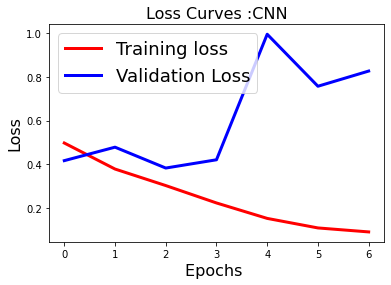

In [105]:
fig1 = plt.figure()
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves :CNN',fontsize=16)
fig1.savefig('loss_cnn.png')
plt.show()

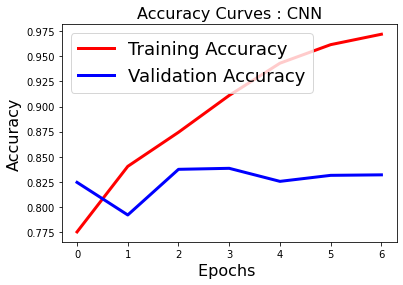

In [106]:
fig2=plt.figure()
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves : CNN',fontsize=16)
fig2.savefig('accuracy_cnn.png')
plt.show()

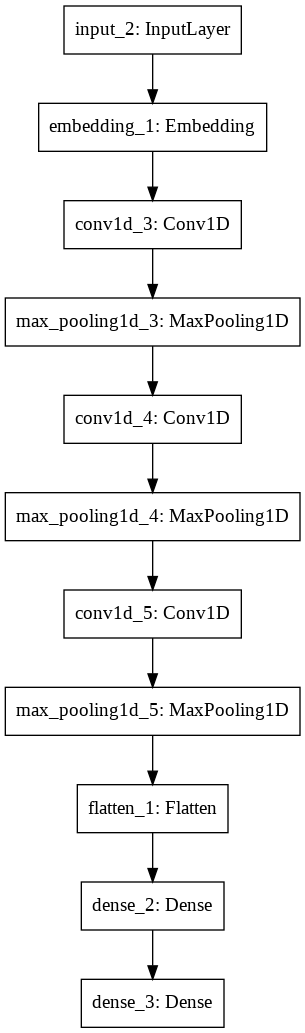

In [114]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='cnn_model.png')